In [1]:
#1. How to process csv files or custom datasets(not keras dataset)
#2. How to use transfer learning
#3. Build an LSTM model
#4. Stacked LSTM
#5. Predictions (i/p: sentence  o/p: most suitable class)

In [2]:
import os, sys, email,re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
#from subprocess import check_output

#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

## Step 1: Load dataset

In [110]:
# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('./emaildataset.csv')
print(df.shape)
df.head()

(1585, 7)


,From,To,Subject,Body,Class,TransactionID,Payment Date
0,Dave@HSBC.com,liFang@CitiBankNewYork.com,Payment Status for 996352,Regret to inform that transaction EUR 921984 c...,BankFailed,996352,2019-10-21
1,Angella@SBI.com,Suhail@CitiBankSingapore.com,Transaction is in progress for 945324,Fund transfer for Account No. 945324 has stopp...,BankProgress,945324,2019-04-13
2,Phillip@SBI.com,AjayNager@CitiBankPune.com,Current Update on Account No. 236195,"Sorry, due to high volume of requests, your tr...",BankProgress,236195,2018-12-06
3,Mike@HDFC.com,Shubhanshu@CitiBankSingapore.com,Transaction Complete for 565267,Full payment for amount EUR 215164 has been su...,BankComplete,565267,2020-01-09
4,Stacy@JPMorgan.com,AjayNager@CitiBankLondon.com,Transaction Failed for 275122,"Due to lack of funds, cheque no. 9389748142575...",BankFailed,275122,2019-06-22


In [111]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [112]:
train.shape

(1268, 7)

In [113]:
# df = df.reindex(columns=columns_titles, inplace=True)
train.Class.unique()

array(['BankComplete', 'BankRequest', 'BankProgress', 'BankFailed',
       'ClientStatus', 'ClientProgress', 'ClientComplete', 'ClientFailed'],
      dtype=object)

In [114]:
test.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date
827,Stacy@DESHAW.com,Shubhanshu@CitiBankPune.com,Transaction is in progress for 362541,"Sorry, due to high volume of requests, your tr...",BankProgress,362541,2019-08-02
255,Phillip@DEUTSCHEBANK.com,Isabella@CitiBankLondon.com,Transaction Failed for 352769,"Due to unknown technical errors, your transact...",BankFailed,352769,2019-08-04
725,Angella@HDFC.com,Dipesh@CitiBankSingapore.com,Current Update on Account No. 176335,Fund transfer for Account No. 176335 has stopp...,BankProgress,176335,2020-02-12
1381,Jason@BNYMellon.com,Shubhanshu@CitiBankHingKong.com,Update on payment request for 894336,Kindly reply to me at the earliest with the la...,ClientStatus,894336,2020-02-07
587,Morgan@DESHAW.com,Shanguisi@CitiBankHingKong.com,Request have been recieved for T-ID: 393165,Request you to resend details of 393165 as soo...,BankRequest,393165,2019-06-17


In [115]:
# import preprocessing from sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 

In [116]:
le = LabelEncoder()
le2 = LabelEncoder()

train['Class'] = le.fit_transform(train['Class'])
test['Class'] = le2.fit_transform(test['Class'])

/home/aheli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/aheli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [117]:
train.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date
91,Stefeny@DEUTSCHEBANK.com,Shanguisi@CitiBankLondon.com,Transaction Complete for 742658,We are happy to let you know that transaction ...,0,742658,2019-11-30
686,Jason@BNYMellon.com,liFang@CitiBankHingKong.com,Request have been recieved for T-ID: 419464,Please find the details of your account 419464...,3,419464,2019-05-11
103,Stacy@HSBC.com,Anthony@CitiBankPune.com,Transaction is in progress for 437497,We are sorry but your fund transfer 437497 is ...,2,437497,2019-01-16
526,Morgan@DEUTSCHEBANK.com,Isabella@CitiBankLondon.com,Transaction Failed for 819525,"Due to incorrect details filled, EUR 318521 ha...",1,819525,2020-02-22
759,Stefeny@DESHAW.com,liFang@CitiBankHingKong.com,Transaction Failed for 217152,Payment of CAD 878869 has been cancelled as pe...,1,217152,2019-12-24


In [118]:
test.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date
827,Stacy@DESHAW.com,Shubhanshu@CitiBankPune.com,Transaction is in progress for 362541,"Sorry, due to high volume of requests, your tr...",2,362541,2019-08-02
255,Phillip@DEUTSCHEBANK.com,Isabella@CitiBankLondon.com,Transaction Failed for 352769,"Due to unknown technical errors, your transact...",1,352769,2019-08-04
725,Angella@HDFC.com,Dipesh@CitiBankSingapore.com,Current Update on Account No. 176335,Fund transfer for Account No. 176335 has stopp...,2,176335,2020-02-12
1381,Jason@BNYMellon.com,Shubhanshu@CitiBankHingKong.com,Update on payment request for 894336,Kindly reply to me at the earliest with the la...,7,894336,2020-02-07
587,Morgan@DESHAW.com,Shanguisi@CitiBankHingKong.com,Request have been recieved for T-ID: 393165,Request you to resend details of 393165 as soo...,3,393165,2019-06-17


In [119]:
# creating instance of one-hot-encoder

enc = OneHotEncoder(handle_unknown='ignore')
# enc2 = OneHotEncoder()
enc_train = pd.DataFrame(enc.fit_transform(train[['Class']]).toarray())

# merge with main df on key values
train = train.join(enc_train)
train.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,0,1,2,3,4,5,6,7
91,Stefeny@DEUTSCHEBANK.com,Shanguisi@CitiBankLondon.com,Transaction Complete for 742658,We are happy to let you know that transaction ...,0,742658,2019-11-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
686,Jason@BNYMellon.com,liFang@CitiBankHingKong.com,Request have been recieved for T-ID: 419464,Please find the details of your account 419464...,3,419464,2019-05-11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,Stacy@HSBC.com,Anthony@CitiBankPune.com,Transaction is in progress for 437497,We are sorry but your fund transfer 437497 is ...,2,437497,2019-01-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
526,Morgan@DEUTSCHEBANK.com,Isabella@CitiBankLondon.com,Transaction Failed for 819525,"Due to incorrect details filled, EUR 318521 ha...",1,819525,2020-02-22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
759,Stefeny@DESHAW.com,liFang@CitiBankHingKong.com,Transaction Failed for 217152,Payment of CAD 878869 has been cancelled as pe...,1,217152,2019-12-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
enc2 = OneHotEncoder(handle_unknown='ignore')
enc_test = pd.DataFrame(enc2.fit_transform(test[['Class']]).toarray())
test = test.join(enc_test)
test.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,0,1,2,3,4,5,6,7
827,Stacy@DESHAW.com,Shubhanshu@CitiBankPune.com,Transaction is in progress for 362541,"Sorry, due to high volume of requests, your tr...",2,362541,2019-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255,Phillip@DEUTSCHEBANK.com,Isabella@CitiBankLondon.com,Transaction Failed for 352769,"Due to unknown technical errors, your transact...",1,352769,2019-08-04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
725,Angella@HDFC.com,Dipesh@CitiBankSingapore.com,Current Update on Account No. 176335,Fund transfer for Account No. 176335 has stopp...,2,176335,2020-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,Jason@BNYMellon.com,Shubhanshu@CitiBankHingKong.com,Update on payment request for 894336,Kindly reply to me at the earliest with the la...,7,894336,2020-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
587,Morgan@DESHAW.com,Shanguisi@CitiBankHingKong.com,Request have been recieved for T-ID: 393165,Request you to resend details of 393165 as soo...,3,393165,2019-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 2: Processing a custom dataset

In [10]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text_Data'] = df['Subject'] + " " + df['Body']

In [11]:
#convert sentences to embeddings and classes to one-hot vectors

In [12]:
embeddings = {}
with open('../data_science/Machine-learning-master/17. Word2Vec/glove.6B.50d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        
#         print(word)
#         print(coeffs)
        embeddings[word] = coeffs
    f.close()
print(len(embeddings))

400000


In [13]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from", "gbp", "usd", "eur", "cad", "sent","thanks", "acc", "ID", "account", "regards", "hi", "hello", "thank you"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # EXTRACT AMOUNT + CURRENCY!!
    #amount = "".join([i for i in text.lower().split() if i.isdigit()])
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    stem = " ".join(porter.stem(token) for token in normalized.split())
    
#     return normalized, amount
    return normalized

In [14]:
# sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]

# for text in df['Text_Data']:
#     text_clean.append(clean(text))
#     text_clean.append(clean(text).split())
#     amount = clean(text)[1]

for i in range(df.shape[0]):
    text_clean.append(clean(df.loc[i]['Text_Data']))

# amount
text_clean[0]

'payment status regret inform transaction could completed due mismatch detail'

In [15]:
df['Text_Data'] = text_clean

In [16]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,0,1,2,3,4,5,6,7,Text_Data
0,Dave@HSBC.com,liFang@CitiBankNewYork.com,Payment Status for 996352,Regret to inform that transaction EUR 921984 c...,1,996352,2019-10-21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,payment status regret inform transaction could...
1,Angella@SBI.com,Suhail@CitiBankSingapore.com,Transaction is in progress for 945324,Fund transfer for Account No. 945324 has stopp...,2,945324,2019-04-13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,transaction progress fund transfer stopped abr...
2,Phillip@SBI.com,AjayNager@CitiBankPune.com,Current Update on Account No. 236195,"Sorry, due to high volume of requests, your tr...",2,236195,2018-12-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,current update sorry due high volume request t...
3,Mike@HDFC.com,Shubhanshu@CitiBankSingapore.com,Transaction Complete for 565267,Full payment for amount EUR 215164 has been su...,0,565267,2020-01-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,transaction complete full payment amount succe...
4,Stacy@JPMorgan.com,AjayNager@CitiBankLondon.com,Transaction Failed for 275122,"Due to lack of funds, cheque no. 9389748142575...",1,275122,2019-06-22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,transaction failed due lack fund cheque bounce...


## Step 4 - Converting sentences to vectors (creating the o/p of embedding layer)

In [17]:
def getOutputEmbeddings(X):
    
    #let 10 is max len of sentence, 50 batch size (no. of e.g.)
    embedding_matrix_output = np.zeros((X.shape[0],100,50))
    
    for ix in range(X.shape[0]):
        X[ix] = X[ix].split()
        for jx in range(len(X[ix])):
            #go to every word in current(ix) sentence
            embedding_matrix_output[ix][jx] = embeddings[X[ix][jx].lower()]
            
    return embedding_matrix_output

In [18]:
# X = df.values
# # Create Training and Testing Set
# X_ = X[:, 0:5]
# Y_ = X[:, -1]

# import sklearn.model_selection as model_selection

# X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_, Y_, train_size=0.8,test_size=0.2)

# print(X_[0])
# print(Y_[0])

In [19]:
XT = df['Text_Data']
# Xt = df2['Text_Data']

print(XT[0])
print(XT.shape)

# print(Xt[0])
# print(Xt.shape)

payment status regret inform transaction could completed due mismatch detail
(1585,)


In [20]:
embed_matrix_train = getOutputEmbeddings(XT)
print(embed_matrix_train.shape)

/home/aheli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(1585, 100, 50)


In [21]:
from keras.utils import to_categorical

YT = to_categorical(df['Class'], num_classes=8)
#Yt = to_categorical(df2['Class'], num_classes=8)

print(YT.shape)
# print(Yt.shape)

Using TensorFlow backend.


(1585, 8)


In [22]:
embed_matrix_test = getOutputEmbeddings(Xt)
print(embed_matrix_test.shape)

NameError: name 'Xt' is not defined

## Step 5: Define RNN/LSTM model 

In [89]:
from keras.layers import *
from keras.models import Sequential

In [90]:
model = Sequential()
model.add(LSTM(64,input_shape=(100,50),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64,input_shape=(100,50), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(8))
model.add(Activation('softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc']) # try optimizer='rmsprop'
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 64)            29440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 62,789
Trainable params: 62,789
Non-trainable params: 0
__________________________________________________

In [91]:
# TRAIN MODEL

In [92]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpt = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=True, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=10)

hist = model.fit(embed_matrix_train,YT,batch_size=32,epochs=40,shuffle=True,validation_split=0.2, callbacks=[checkpt, earlystop])
# consider params --> model.fit(X_train,YT,validation_split=0.2,epochs=10,batch_size=128)

Train on 105 samples, validate on 27 samples
Epoch 1/40
105/105 [==============================] - 1s 9ms/step - loss: 1.5876 - acc: 0.2571 - val_loss: 1.6177 - val_acc: 0.1852

Epoch 00001: val_loss improved from inf to 1.61768, saving model to best_model.h5
Epoch 2/40
105/105 [==============================] - 0s 529us/step - loss: 1.5314 - acc: 0.3238 - val_loss: 1.6585 - val_acc: 0.2963

Epoch 00002: val_loss did not improve from 1.61768
Epoch 3/40
105/105 [==============================] - 0s 672us/step - loss: 1.4945 - acc: 0.3429 - val_loss: 1.6792 - val_acc: 0.2222

Epoch 00003: val_loss did not improve from 1.61768
Epoch 4/40
105/105 [==============================] - 0s 551us/step - loss: 1.4661 - acc: 0.3714 - val_loss: 1.6625 - val_acc: 0.2222

Epoch 00004: val_loss did not improve from 1.61768
Epoch 5/40
105/105 [==============================] - 0s 956us/step - loss: 1.4012 - acc: 0.4190 - val_loss: 1.6090 - val_acc: 0.1852

Epoch 00005: val_loss improved from 1.61768 to 

In [93]:
pred = model.predict_classes(embed_matrix_test)

print(pred)

[4 3 2 2 2 2 1 2 4 2 1 2 0 2 1 3 2 2 3 2 0 0 4 2 3 1 2 0 1 2 0 1 0 2 0 1 2
 3 4 2 1 0 0 1 2 2 2 2 0 1 1 0 3 2 3 0]


In [94]:
model.evaluate(embed_matrix_test,Yt)

56/56 [==============================] - 0s 387us/step


[1.7502823386873518, 0.5714285969734192]

In [ ]:
# for i in range(30):
#     print(' '.join(Xt[i]))
#     print(emoji.emojize(emoji_dictionary[str(np.argmax(Yt[i]))]))
#     print(emoji.emojize(emoji_dictionary[str(pred[i])]))

In [14]:
model.save("mymodel.h5")

#our model starts to overfit after a certain point. We can save the model upto the point where we get max valdn acc
#done using callback

In [15]:
!ls

best_model.h5		       IMDB_Classification_RNN_LSTM.ipynb  mymodel.h5
IMBD_Classification_MLP.ipynb  Img.jpeg


## Testing with random strings

In [96]:
with open("model.json", "w") as file:
    file.write(model.to_json())
model.save_weights("model.h5")

In [97]:
from keras.models import model_from_json

In [98]:
with open("model.json", "r") as file:
    model=model_from_json(file.read())
model.load_weights("model.h5")

In [99]:
test_str="hello, is my payment done yet?"
X = pd.Series(test_str)
print(type(X))

<class 'pandas.core.series.Series'>


In [119]:
def getOutputEmbeddings(X):  
    X = X.split()
    embedding_matrix_output = np.zeros((1,10,50))
    for jx in range(len(X)):
        embedding_matrix_output[0][jx] = embeddings[X[jx].lower()]
            
    return embedding_matrix_output

In [120]:
emb_X = getOutputEmbeddings(test_str)

In [121]:
p = model.predict_classes(emb_X)

In [123]:
p[0]

2

## Visualise our results

In [0]:
import matplotlib.pyplot as plt

In [0]:
h = hist.history

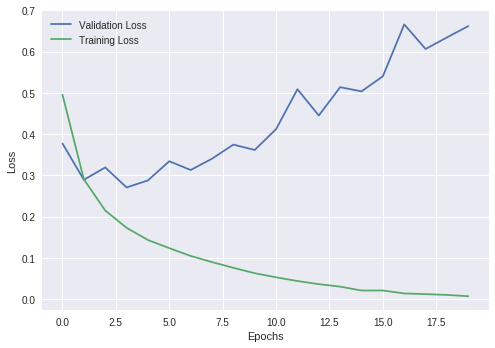

In [0]:
plt.plot(h['val_loss'],label="Validation Loss")
plt.plot(h['loss'],label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

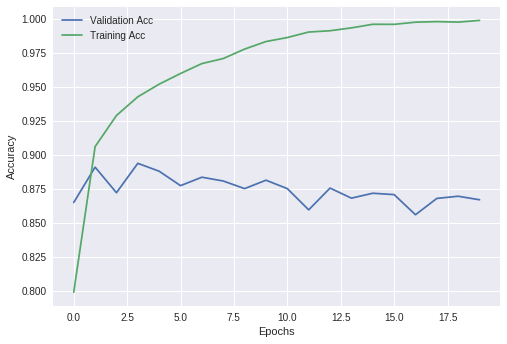

In [0]:
plt.plot(h['val_acc'],label="Validation Acc")
plt.plot(h['acc'],label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [0]:
model.evaluate(X_test,Y_test)[1]

25000/25000 [==============================] - 2s 83us/step


0.8806

In [0]:
model.evaluate(X_train,Y_train)[1]

25000/25000 [==============================] - 2s 84us/step


0.9428

In [0]:
model.predict(X_test)

array([[0.32389975],
       [0.999739  ],
       [0.67278445],
       ...,
       [0.16619593],
       [0.15570958],
       [0.6937666 ]], dtype=float32)

In [ ]:
## Visualise our results

import matplotlib.pyplot as plt

h = hist.history

plt.plot(h['val_loss'],label="Validation Loss")
plt.plot(h['loss'],label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(h['val_acc'],label="Validation Acc")
plt.plot(h['acc'],label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

model.evaluate(X_test,Y_test)[1]



model.evaluate(X_train,Y_train)[1]

model.predict(X_test)



## Cells that may be useful

In [ ]:
combined = list(zip(data, labels))
random.shuffle(combined)

data[:], labels[:] = zip(*combined)

In [ ]:
hist = model_new.fit(X_train, Y_train,
                    shuffle = True,
                    batch_size=16,
                    epochs=5, #most wts have already been trained so dont need large no of epochs
                    validation_split=0.20)